In [1]:
#%% Cell 1: Imports and Configuration
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

# Configuration
dataset_path = r"D:\Curtis_2nd_cropped_image\Face recognition cropped"
prototxt_path = r"D:\deploy.prototxt.txt"
caffemodel_path = r"D:\res10_300x300_ssd_iter_140000.caffemodel"
eye_cascade_path = 'haarcascade_eye.xml'
target_size = (100, 100)
n_components = 25
base_confidence_threshold = 0.7
min_face_size = 50
threshold_multiplier = 2

In [2]:
#%% Cell 2: PCA Class with Eigenvalue Storage
class ManualPCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.mean = None
        self.components = None
        self.eigenvalues = None
    
    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        cov_matrix = np.cov(X_centered, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        idx = np.argsort(eigenvalues)[::-1]
        self.eigenvalues = eigenvalues[idx]
        self.components = eigenvectors[:, idx][:, :self.n_components]
    
    def transform(self, X):
        return np.dot(X - self.mean, self.components)

In [3]:
#%% Cell 3: Image Processing Functions
def augment_face(face):
    augmented = [face]
    augmented.append(cv2.flip(face, 1))
    for angle in [-15, 15]:
        M = cv2.getRotationMatrix2D((face.shape[1]//2, face.shape[0]//2), angle, 1)
        rotated = cv2.warpAffine(face, M, (face.shape[1], face.shape[0]))
        augmented.append(rotated)
    augmented.append(cv2.GaussianBlur(face, (3,3), 0))
    bright = cv2.convertScaleAbs(face, alpha=1.3, beta=40)
    augmented.append(bright)
    return augmented

def preprocess_face(face):
    face_eq = cv2.equalizeHist(face)
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
    return clahe.apply(face_eq)

def align_face(gray_face, eye_cascade):
    if gray_face.shape[0] < min_face_size or gray_face.shape[1] < min_face_size:
        return gray_face
    try:
        eyes = eye_cascade.detectMultiScale(gray_face, scaleFactor=1.05, minNeighbors=8, minSize=(35,35))
        if len(eyes) >= 2:
            eyes = sorted(eyes, key=lambda x: x[0])
            left_eye = (eyes[0][0] + eyes[0][2]//2, eyes[0][1] + eyes[0][3]//2)
            right_eye = (eyes[1][0] + eyes[1][2]//2, eyes[1][1] + eyes[1][3]//2)
            
            dx = right_eye[0] - left_eye[0]
            dy = right_eye[1] - left_eye[1]
            angle = np.degrees(np.arctan2(dy, dx))
            
            center = (gray_face.shape[1]//2, gray_face.shape[0]//2)
            M = cv2.getRotationMatrix2D(center, angle, 1)
            return cv2.warpAffine(gray_face, M, gray_face.shape[::-1], flags=cv2.INTER_CUBIC)
        return gray_face
    except:
        return gray_face

In [4]:
#%% Cell 4: Data Loading & Initial Visualizations
def load_training_data(dataset_path):
    net = cv2.dnn.readNetFromCaffe(prototxt_path, caffemodel_path)
    eye_cascade = cv2.CascadeClassifier(eye_cascade_path)
    X, labels = [], []

    # Collect first 10 images for visualization
    first_10_images = []

    for person_name in os.listdir(dataset_path):
        person_dir = os.path.join(dataset_path, person_name)
        if not os.path.isdir(person_dir):
            continue

        for img_name in os.listdir(person_dir):
            img_path = os.path.join(person_dir, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue

            h, w = img.shape[:2]
            blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0,
                                       (300, 300), (104.0, 177.0, 123.0)) 
            net.setInput(blob)
            detections = net.forward()

            for i in range(detections.shape[2]):
                confidence = detections[0, 0, i, 2]
                if confidence > 0.5:
                    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                    startX, startY, endX, endY = box.astype("int")
                    face_roi = img[startY:endY, startX:endX]

                    if face_roi.size == 0:
                        continue

                    gray = cv2.cvtColor(face_roi, cv2.COLOR_BGR2GRAY)
                    aligned = align_face(gray, eye_cascade)
                    processed = preprocess_face(aligned)
                    resized = cv2.resize(processed, target_size)

                    # Store first 10 images
                    if len(first_10_images) < 10:
                        first_10_images.append(resized)

                    for augmented in augment_face(processed):
                        resized = cv2.resize(augmented, target_size)
                        X.append(resized.flatten())
                        labels.append(person_name)
    
    # Plot first 10 images
    plt.figure(figsize=(15, 5))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(first_10_images[i], cmap='gray')
        plt.axis('off')
        plt.title(f"Sample {i+1}")
    plt.suptitle("First 10 Training Images", y=0.95)
    plt.show()
    
    return np.array(X), np.array(labels)

Loading training data...


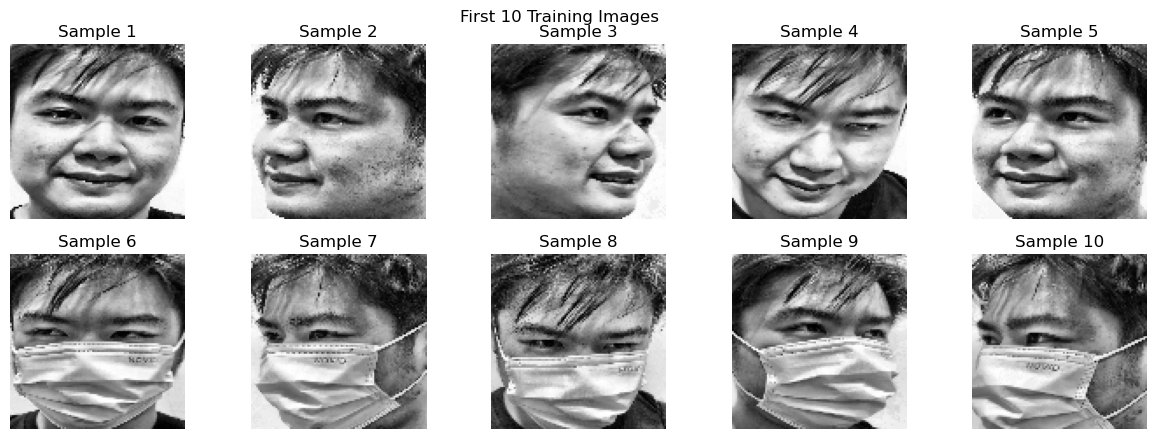

Loaded 2208 training samples
Training PCA...


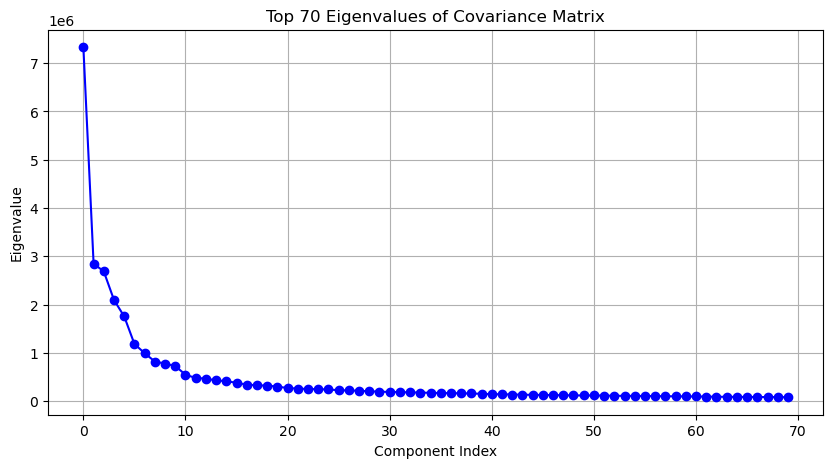

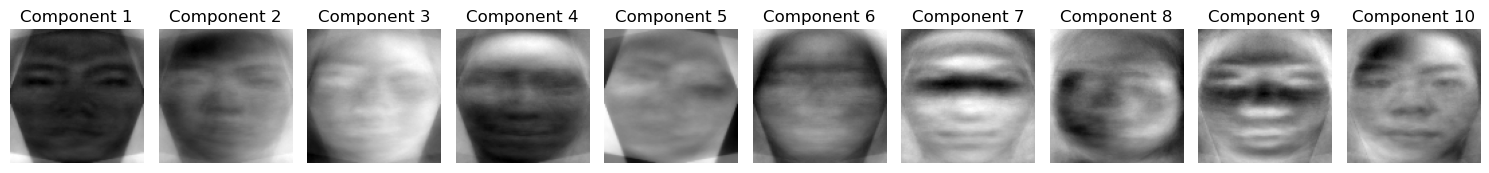

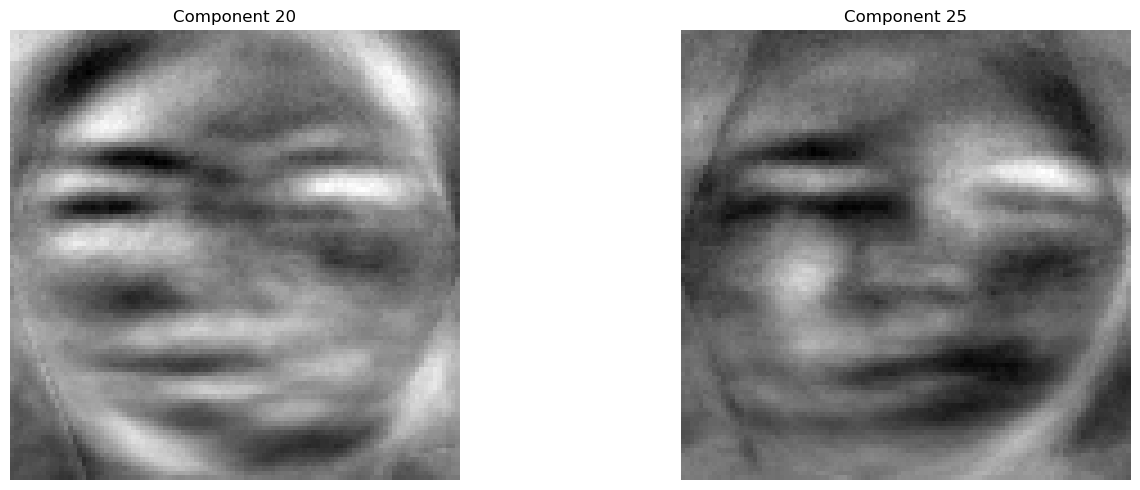

In [5]:
#%% Cell 5: Model Training & Eigen Analysis
# Load data
print("Loading training data...")
X_train, y_train = load_training_data(dataset_path)

if len(X_train) == 0:
    raise ValueError("No training data found! Check your dataset path.")

print(f"Loaded {len(X_train)} training samples")

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_train)

# Train PCA
print("Training PCA...")
pca = ManualPCA(n_components)
pca.fit(X_train)
X_pca = pca.transform(X_train) 

# Eigenvalue visualization
plt.figure(figsize=(10, 5))
plt.plot(pca.eigenvalues[:70], 'b-o')
plt.title('Top 70 Eigenvalues of Covariance Matrix')
plt.xlabel('Component Index')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.show()

# Eigenface visualization function
def plot_eigenfaces(components, target_size, indices):
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, len(indices), i+1)
        eigenface = components[:, idx].reshape(target_size)  # Fixed indexing
        plt.imshow(eigenface, cmap='gray')
        plt.title(f'Component {idx+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# First 10 eigenfaces
plot_eigenfaces(pca.components, target_size, range(10))

# Specific components
plot_eigenfaces(pca.components, target_size, [19, 24])  # Components 20, 25

In [6]:
#%% Cell 6: Recognition System Setup
# Normalize features
X_pca_normalized = X_pca / np.linalg.norm(X_pca, axis=1, keepdims=True)

print("Training classifier...")
knn = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='cosine')
knn.fit(X_pca_normalized, y_encoded)

# Dynamic threshold calculation
def calculate_threshold(X_train_pca, knn):
    distances, _ = knn.kneighbors(X_train_pca, n_neighbors=2)
    distances = distances[:, 1]  # Exclude self
    return np.mean(distances) + threshold_multiplier * np.std(distances)

threshold = calculate_threshold(X_pca_normalized, knn)
print(f"Dynamic recognition threshold: {threshold:.2f}")

Training classifier...
Dynamic recognition threshold: 0.19


In [7]:
#%% Cell 7: Real-Time Recognition
cap = cv2.VideoCapture(0)
net = cv2.dnn.readNetFromCaffe(prototxt_path, caffemodel_path)
eye_cascade = cv2.CascadeClassifier(eye_cascade_path)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    h, w = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0,
                               (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()
    
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            face_roi = frame[startY:endY, startX:endX]
            
            if face_roi.size == 0:
                continue
            
            try:
                gray = cv2.cvtColor(face_roi, cv2.COLOR_BGR2GRAY)
                aligned = align_face(gray, eye_cascade)
                processed = preprocess_face(aligned)
                resized = cv2.resize(processed, target_size).flatten().reshape(1, -1)
                
                face_pca = pca.transform(resized)
                face_pca_normalized = face_pca / np.linalg.norm(face_pca)
                
                distances, _ = knn.kneighbors(face_pca_normalized)
                avg_distance = np.mean(distances)
                confidence = (1 - avg_distance) * 100
                
                if avg_distance > threshold:
                    label = f"Unknown ({confidence:.1f}%)"
                else:
                    pred = knn.predict(face_pca_normalized)
                    name = le.inverse_transform(pred)[0]
                    label = f"{name} ({confidence:.1f}%)"
                
                cv2.rectangle(frame, (startX, startY), (endX, endY), (0,255,0), 2)
                cv2.putText(frame, label, (startX, startY-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)
            
            except Exception as e:
                pass
    
    cv2.imshow("Face Recognition", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()